# DO LSTM Model Post-Hoc Shap Value Analysis
## Harrison Myers
### 4/21/2025

This script conducts post-hoc analysis on the pretrained, finetuned, and site only LSTMs for floodplain DO prediction. 

In [1]:
import os
import numpy as np
import pandas as pd
import shap
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers, metrics
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.preprocessing import MinMaxScaler


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import os

# Back out one directory to project folder
PROJECT_DIR = os.path.dirname(os.path.abspath(''))
os.chdir(PROJECT_DIR)

# Set directories
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
FIGURE_DIR = os.path.join(PROJECT_DIR, 'outputs','figures')
OUTPUT_DIR = os.path.join(PROJECT_DIR, "outputs")
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
CONFIG_DIR = os.path.join(PROJECT_DIR, "config")

# Setup logging
from src.utils.logging_setup import setup_logging
logger = setup_logging(log_dir='logs', log_filename="SHAP_vals.log")

### Read in and preprocess floodplain data

In [12]:
OC2 = pd.read_csv(PROJECT_DIR + r"/data/OC2.csv", index_col=[0])
OC2.index = pd.to_datetime(OC2.index).date
LF1 = pd.read_csv(PROJECT_DIR + r"/data/LF1.csv", index_col=[0])
LF1.index = pd.to_datetime(LF1.index).date
LF2 = pd.read_csv(PROJECT_DIR + r"/data/LF2.csv", index_col=[0])
LF2.index = pd.to_datetime(LF2.index).date
OC4 = pd.read_csv(PROJECT_DIR + r"/data/OC4.csv", index_col=[0])
OC4.index = pd.to_datetime(OC4.index).date
LF3 = pd.read_csv(PROJECT_DIR + r"/data/LF3.csv", index_col=[0])
LF3.index = pd.to_datetime(LF3.index).date
OC1 = pd.read_csv(PROJECT_DIR + r"/data/OC1.csv", index_col=[0])
OC1.index = pd.to_datetime(OC1.index).date
OC3 = pd.read_csv(PROJECT_DIR + r"/data/OC3.csv", index_col=[0])
OC3.index = pd.to_datetime(OC3.index).date

In [13]:
OC2_noNA = OC2.dropna(subset=['o'])
LF1_noNA = LF1.dropna(subset=['o'])
LF2_noNA = LF2.dropna(subset=['o'])
OC4_noNA = OC4.dropna(subset=['o'])
LF3_noNA = LF3.dropna(subset=['o'])
OC1_noNA = OC1.dropna(subset=['o'])
OC3_noNA = OC3.dropna(subset=['o'])

In [14]:
site_dfs_noNA = [OC2_noNA, LF1_noNA, LF2_noNA, OC4_noNA, LF3_noNA, OC1_noNA, OC3_noNA]

In [15]:
data = pd.read_csv(PROJECT_DIR + r"/data/river_training_data.csv", index_col=[0])
data.index = pd.to_datetime(data.index).date
data.head()

data_noNA = data.dropna(subset=['o'])
print(data_noNA.shape)

(1558230, 140)


### Data preprocessing

In [16]:
with open(MODEL_DIR + '/old/vars_to_keep_FS.txt', "r") as file:
    vars_to_keep = [line.strip() for line in file]

for i, df in enumerate(site_dfs_noNA):
    df = df[vars_to_keep]
    df = df.sort_index(axis=1)
    site_dfs_noNA[i] = df
data = data[vars_to_keep]
data_noNA = data_noNA[vars_to_keep]
master_noNA = pd.concat(site_dfs_noNA)

In [17]:
river_site_dfs = {}
data_noNA['site'] = data_noNA.groupby(['lat', 'lon']).ngroup()
sites = data_noNA['site'].unique()
for site in sites:
    temp_df = data_noNA[data_noNA['site'] == site]
    if len(temp_df) >= 365: # only keep sites with a year or more worth of data
        temp_df = temp_df.drop('site', axis=1)
        river_site_dfs[site] = temp_df
    else:
        data_noNA = data_noNA[data_noNA['site'] != site]
    river_site_dfs[site] = temp_df
    
data_noNA.drop('site', axis=1, inplace=True)

In [18]:
data_noNA = data_noNA.sort_index(axis=1)
master_noNA = master_noNA.sort_index(axis=1)

In [65]:
# create a dataframe with USGS and site data for accurate scaling
all_data_df = pd.concat([master_noNA, data_noNA])
all_data_df = all_data_df.sort_index(axis=1)
all_data_df_noDO = all_data_df.drop(['o'], axis=1)

# First fit scaler just to y data for rescaling predictions
scaler_y = MinMaxScaler()
scaler_y.fit(np.array(all_data_df["o"]).reshape(-1, 1))

# Scale dataset
scaler = MinMaxScaler()
scaler.fit(all_data_df.values)
scaler_noDO = MinMaxScaler()
scaler_noDO.fit(all_data_df_noDO.values)

MinMaxScaler()

In [20]:
from utils import preprocessing_functions as ppf
data_sc = ppf.data_pipeline(data, 1e-7, scaler)
data_sc_noNA = ppf.data_pipeline(data_noNA, 1e-7, scaler)

In [24]:
site_dfs_sc = []
for df in site_dfs_noNA:
    df_sc = ppf.data_pipeline(df, 1e-7, scaler)
    site_dfs_sc.append(df_sc)

In [22]:
import yaml
CONFIG_DIR = os.path.join(PROJECT_DIR, 'config')
with open(os.path.join(CONFIG_DIR, 'river_lstm3_config.yaml'), 'r') as f:
    config = yaml.safe_load(f)
    
seed = config['seed']
split_pct = config['split_pct']
window_length = config['window_length']
hidden_layers = config['hidden_layers']
hidden_units = config['hidden_units']
batch_size = config['batch_size']
n_epochs = config['n_epochs']
activation_dense = config['activation_dense']
learning_rate = config['learning_rate']
dropout = config['dropout']
stop_patience = config['stop_patience']
lr_schedule_patience = config['lr_schedule_patience']

In [23]:
import h5py

# Load weights from the HDF5 file
with h5py.File(MODEL_DIR + '/old/River_LSTM.weights.h5', 'r') as f:
    layer_names = list(f['/layers'].keys())  # Get the order of layers
    print("Layer names:", layer_names)
    
    for layer_name in layer_names:
        layer_group = f['/layers'][layer_name]
        print(f"\nMembers of layer '{layer_name}':")
        
        for member_name in layer_group.keys():
            print(f"  {member_name} (type: {type(layer_group[member_name])})")
            
            # If the member is a group, further inspect its contents
            member_group = layer_group[member_name]
            if isinstance(member_group, h5py.Group):
                for sub_member_name in member_group.keys():
                    sub_member = member_group[sub_member_name]
                    print(f"    {sub_member_name} (type: {type(sub_member)})")
                    
                    # If it's a dataset, print its shape and dtype
                    if isinstance(sub_member, h5py.Dataset):
                        print(f"      Shape: {sub_member.shape}, Dtype: {sub_member.dtype}")

                    # If it's another group, further delve into it
                    elif isinstance(sub_member, h5py.Group):
                        print(f"    Inspecting nested group '{sub_member_name}' in '{layer_name}':")
                        for nested_name in sub_member.keys():
                            nested_member = sub_member[nested_name]
                            print(f"      {nested_name} (type: {type(nested_member)})")
                            if isinstance(nested_member, h5py.Dataset):
                                print(f"        Shape: {nested_member.shape}, Dtype: {nested_member.dtype}")
                        

Layer names: ['dense', 'dropout', 'lstm']

Members of layer 'dense':
  vars (type: <class 'h5py._hl.group.Group'>)
    0 (type: <class 'h5py._hl.dataset.Dataset'>)
      Shape: (8, 1), Dtype: float32
    1 (type: <class 'h5py._hl.dataset.Dataset'>)
      Shape: (1,), Dtype: float32

Members of layer 'dropout':
  vars (type: <class 'h5py._hl.group.Group'>)

Members of layer 'lstm':
  cell (type: <class 'h5py._hl.group.Group'>)
    vars (type: <class 'h5py._hl.group.Group'>)
    Inspecting nested group 'vars' in 'lstm':
      0 (type: <class 'h5py._hl.dataset.Dataset'>)
        Shape: (35, 32), Dtype: float32
      1 (type: <class 'h5py._hl.dataset.Dataset'>)
        Shape: (8, 32), Dtype: float32
      2 (type: <class 'h5py._hl.dataset.Dataset'>)
        Shape: (32,), Dtype: float32
  vars (type: <class 'h5py._hl.group.Group'>)


In [25]:
X_OC2, y_OC2 = ppf.reshape_data(site_dfs_sc[0].drop(['o'], axis=1), site_dfs_sc[0]['o'], window_length)
X_LF1, y_LF1 = ppf.reshape_data(site_dfs_sc[1].drop(['o'], axis=1), site_dfs_sc[1]['o'], window_length)
X_LF2, y_LF2 = ppf.reshape_data(site_dfs_sc[2].drop(['o'], axis=1), site_dfs_sc[2]['o'], window_length)
X_OC4, y_OC4 = ppf.reshape_data(site_dfs_sc[3].drop(['o'], axis=1), site_dfs_sc[3]['o'], window_length)
X_LF3, y_LF3 = ppf.reshape_data(site_dfs_sc[4].drop(['o'], axis=1), site_dfs_sc[4]['o'], window_length)
X_OC1, y_OC1 = ppf.reshape_data(site_dfs_sc[5].drop(['o'], axis=1), site_dfs_sc[5]['o'], window_length)
X_OC3, y_OC3 = ppf.reshape_data(site_dfs_sc[6].drop(['o'], axis=1), site_dfs_sc[6]['o'], window_length)
X_master_rs = np.concatenate([X_OC2, X_LF1, X_LF2, X_OC4, X_LF3, X_OC1, X_OC3], axis=0)
np.random.shuffle(X_master_rs)
y_master_rs = np.concatenate([y_OC2, y_LF1, y_LF2, y_OC4, y_LF3, y_OC1, y_OC3])

In [26]:
print(X_master_rs.shape)

(3713, 9, 35)


In [27]:
def build_model_shap(hidden_layers, hidden_units, optimizer, window_length, n_features, lr, dropout=0, custom_loss_fn=None, mask=False, batch_norm=False, mask_val=-1, activation_dense="relu"):
    loss_fn = custom_loss_fn if custom_loss_fn else 'mean_squared_error'
    optimizer = optimizer
    model = keras.Sequential()
    model.add(layers.Input(shape=(window_length-1, n_features)))

    if mask:
        model.add(layers.Masking(mask_value=mask_val, input_shape=(window_length-1, n_features)))
    for i in range(hidden_layers):
        if i != hidden_layers - 1:
            model.add(layers.LSTM(units=hidden_units, return_sequences=True))
            model.add(layers.Dropout(dropout))
            if batch_norm:
                model.add(layers.BatchNormalization())
        else:
            model.add(layers.LSTM(units=hidden_units))
            model.add(layers.Dropout(dropout))
            if batch_norm: 
                model.add(layers.BatchNormalization())
    model.add(layers.Dense(units=1, activation=activation_dense))
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=["mean_absolute_error", metrics.RootMeanSquaredError()])
    # model.summary()
              
    return model

In [270]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats

def shap_beeswarm_kdepoints(
    shap_values,
    data,
    feature_names,
    expected_values=None,
    *,
    max_display=15,
    cmap=mpl.cm.get_cmap("coolwarm"),
    point_size=9,
    n_grid=200,
    max_half_height=0.3,
    figsize=(12, 6),
    ax=None,
    show=True,
    x_min=None,
    x_max=None,
    colorbar=True
):
    """Beeswarm where the point cloud itself traces the KDE/violin shape."""
    shap_values = np.asarray(shap_values)
    # x_min = np.min(np.min(shap_values, axis=0)) * 1.1
    # x_max = np.max(np.max(shap_values, axis=0)) * 1.1
    data        = np.asarray(data)
    if shap_values.shape != data.shape:
        raise ValueError("`shap_values` and `data` must have identical shape.")

    n_samples, n_features = shap_values.shape
    max_display = min(max_display, n_features)

    # ‑‑‑ 1. rank features
    mean_abs = np.mean(np.abs(shap_values), axis=0)
    feat_order = np.argsort(mean_abs)[::-1][:max_display]

    # ‑‑‑ 2. colour normalisation
    vmin = np.nanpercentile(data[:, feat_order],  0)
    vmax = np.nanpercentile(data[:, feat_order], 100)
    norm = mpl.colors.Normalize(vmin, vmax)

    # ‑‑‑ 3. figure boiler‑plate
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    # 4. loop bottom→top so most‑important ends up on top
    for row, feat_idx in enumerate(feat_order[::-1]):
        sv = shap_values[:, feat_idx]
        fv = data[:,  feat_idx]

        # 4a ‑ KDE on fixed grid
        kde = stats.gaussian_kde(sv, bw_method="scott")
        xs  = np.linspace(sv.min(), sv.max(), n_grid)
        dens = kde(xs)
        dens = dens / dens.max() * max_half_height

        # 4b ‑ assign each sample to nearest grid point
        bin_idx = np.searchsorted(xs, sv, side="left")
        bin_idx = np.clip(bin_idx, 1, n_grid-1) - 1

        y_off = np.zeros_like(sv)
        for b in np.unique(bin_idx):
            pts = np.where(bin_idx == b)[0]
            if not len(pts):
                continue
            h = dens[b]
            k = len(pts)
            offs = np.linspace(-h, h, k)
            ordering = np.argsort(np.abs(sv[pts]))[::-1]
            y_off[pts[ordering]] = offs

        # 4c ‑‑‑ Plot the points
        ax.scatter(
            sv,
            row + y_off,
            s=point_size,
            c=cmap(norm(fv)),
            alpha=0.8,
            linewidth=0,
            rasterized=True,
        )

    # 5. axes cosmetics
    ax.axvline(0, color="grey", lw=0.8)
    if expected_values is not None:
        base = np.median(expected_values) if np.ndim(expected_values) else expected_values
        ax.axvline(base, color="grey", lw=0.8, ls="--")

    yticks = np.arange(max_display)
    ax.set_yticks(yticks)
    ax.set_yticklabels([feature_names[i] for i in feat_order[::-1]])
    ax.set_ylim(-1, max_display)
    ax.set_xlim(x_min, x_max)
    ax.set_xlabel("SHAP value")
    ax.grid(axis="x", ls=":", lw=0.4)

    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    if colorbar:
        cbar = fig.colorbar(sm, ax=ax, pad=0.02)
        cbar.outline.set_visible(False)

        cbar.set_label("Feature value", rotation=270, labelpad=15)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)


    fig.tight_layout()
    if show:
        plt.show()
    
    return fig, ax


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import shap

def shap_bar_plot(
    shap_exp,
    *,
    max_display=20,
    color="#fc0454",   # SHAP’s default diverging palette
    axis_color="#333333",
    text_color="#333333",
    bar_thickness=0.6,
    show=True,
    figsize=(6, 4),
    ax=None,
    x_max=None
):
    """
    Bar plot of global feature importance (mean|SHAP|) **without** the
    automatic "Sum of n other features" bar that SHAP’s built‑in bar plot
    adds when `max_display < n_features`.

    Parameters
    ----------
    shap_exp : shap.Explanation or (values, feature_names) tuple
        A 2‑D SHAP Explanation (or matrix) for a single‑output model.
    max_display : int, default 20
        Show at most this many most‑important features.  No aggregate bar is
        added even when fewer than n_features are displayed.
    color : matplotlib colormap or callable, default SHAP red‑blue
        Colour map used for the bars; called with [0‑1] importance scaling.
    axis_color, text_color : str
        Colours for axes / tick labels / bar annotations.
    bar_thickness : float, default 0.6
        Height of each horizontal bar (in axes coordinates).
    value_format : str
        Format‐string for the numeric annotation at bar ends.
    show : bool, default True
        If True, calls `plt.show()` at the end.
    figsize : tuple, default (6, 4)
        Figure size if `ax` is not provided.
    ax : matplotlib.axes.Axes, optional
        If given, draw into this existing axes; otherwise a new figure/
        axes is created.

    Returns
    -------
    fig, ax : the Matplotlib Figure and Axes objects.
    """
    # ------------- 0. Unpack / validate inputs ---------------------------
    if isinstance(shap_exp, shap._explanation.Explanation):
        shap_values = shap_exp.values
        feature_names = shap_exp.feature_names
    else:
        shap_values, feature_names = shap_exp  # assume iterable/tuple

    shap_values = np.asarray(shap_values)
    if shap_values.ndim != 2:
        raise ValueError("`shap_exp` must be 2‑D (n_samples, n_features)")

    n_samples, n_features = shap_values.shape
    if len(feature_names) != n_features:
        raise ValueError("feature_names length mismatch")

    # ------------- 1. Global importance & ordering -----------------------
    mean_abs = np.mean(np.abs(shap_values), axis=0)
    mean_raw = np.mean(shap_values, axis=0)      # sign for colour map
    order = np.argsort(mean_abs)[::-1]

    # limit how many bars to draw
    k = min(max_display, n_features)
    order = order[:k]

    mean_abs = mean_abs[order]
    mean_raw = mean_raw[order]
    labels   = np.array(feature_names, dtype=str)[order]

    # ------------- 2. Make / reuse axes ----------------------------------
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    # ------------- 3. Draw horizontal bars ------------------------------
    y_pos = np.arange(k)   # most important at top
    bars  = ax.barh(
        y_pos,
        mean_abs,
        height=bar_thickness,
        color=color,
        edgecolor="none",
    )

    # ------------- 4. Annotate bars with ±value -------------------------
    for bar, val in zip(bars, mean_abs):
        x = bar.get_width()
        y = bar.get_y() + bar.get_height() / 2
        ax.text(
            x + mean_abs.max() * 0.01,  # small offset
            y,
            round(x, 4),
            va="center",
            ha="left",
            fontsize=9,
            color=text_color,
        )

    # ------------- 5. Axes styling --------------------------------------
    if x_max is None:
        x_max = mean_abs.max() * 1.15
    else:
        x_max = x_max
        
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=10, color=text_color)
    ax.invert_yaxis()                   # top‑rank first
    ax.set_xlabel("mean(|SHAP value|)", color=axis_color)
    ax.tick_params(axis="x", colors=axis_color)
    ax.tick_params(axis="y", colors=axis_color)
    ax.grid(axis="x", ls=":", lw=0.4)
    ax.set_xlim(0, x_max)

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    fig.tight_layout()

    if show:
        plt.show()

    return fig, ax


In [ ]:
tf.compat.v1.disable_eager_execution()
import tensorflow.python.keras.backend as K
with h5py.File(MODEL_DIR + '/old/River_LSTM.weights.h5', 'r') as f:
    with tf.compat.v1.Session() as sess:
        K.set_session(sess)
        # Build the model
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        n_features = len(X_master_rs.columns)
        model = build_model_shap(hidden_layers, hidden_units, optimizer, window_length, n_features,
                            dropout=dropout, lr=learning_rate, custom_loss_fn=None, batch_norm=False)
        model.summary()
        
        # Layer names as per the HDF5 file
        dense_vars = f['/layers/dense/vars']
        lstm_vars = f['/layers/lstm/cell/vars']
        
        # Extract weights from the file and assign to model layers
        # LSTM layer weights (order: [kernel, recurrent_kernel, bias])
        
        lstm_weights = [np.array(lstm_vars[str(i)]) for i in range(len(lstm_vars))]
        model.layers[0].set_weights(lstm_weights)
        
        # Dense layer weights (order: [kernel, bias])
        dense_weights = [np.array(dense_vars[str(i)]) for i in range(len(dense_vars))]
        model.layers[2].set_weights(dense_weights)
        
        explainer_PT = shap.DeepExplainer(model, X_master_rs[:1000], session=sess)
        shap_values_PT = explainer_PT.shap_values(X_master_rs[:1000])

2025-04-21 11:04:44.978140: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-04-21 11:04:44.978220: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 8)                 1408      
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,417
Trainable params: 1,417
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [54]:
# Create Explanation object from shap values for plotting purposes
shap_explainer = shap.Explanation(values=shap_values_PT, base_values=explainer_PT.expected_value, data=X_master_rs[:1000])

# Flatten shap values along the second dimension to turn (1000, 9, 35) array into (9000, 35) array
shap_values_2d = shap_explainer[0].values.reshape(-1, shap_explainer[0].values.shape[-1])   # (9000, 35)
data_2d = shap_explainer.data.reshape(-1, shap_explainer.data.shape[-1])
print(shap_values_2d.shape, data_2d.shape)

(9000, 35) (9000, 35)


In [72]:
# Get list of feature names and drop target feature column
feature_names = list(site_dfs_noNA[0].columns)
feature_names.remove('o')
print(feature_names)
feature_name_dict = {'ARTIFICIAL': '% Artificial flowpaths',
                     'BASIN_AREA': "Catchment area",
                     'BEDPERM_6': "% Bedrock: unconsolidated sand and gravel",
                     'BFI': 'Baseflow index',
                     'CNPY11_BUFF100': "% Tree canopy in 100m riparian buffer",
                     'CONTACT': "Subsurface flow contact time (d)",
                     'ELEV_MAX': "Maximum catchment elevation (m)",
                     'ELEV_MEAN': "Mean elevation (m)",
                     'ELEV_MIN': 'Minimum catchment elevation (m)',
                     'FUNGICIDE': 'Fungicide use',
                     'HGAD': "% of hydrologic group AD soil",
                     'HGC': '% of hydrologic group C soil', 
                     'LAKEPOND': "% Lakes or ponds",
                     'N97': "Nitrogen from fertilizer/manure (1997)",
                     'NLCD01_52': "% Shrub/scrub",
                     'NLCD01_81': "% Pasture/hay",
                     'NLCD01_95': "% Emergent wetlands",
                     'RH': 'Relative humidity (%)',
                     'SALINAVE': 'Mean salinity (mohms/cm)',
                     'SANDAVE': 'Mean % sand',
                     'SILTAVE': "Mean % silt",
                     'STRM_DENS': "Stream density",
                     'WDANN': "Average days/year with precipitation",
                     'dayl (s)': 'Day length (s)',
                     'lat': 'Latitude',
                     'lon': 'Longitude',
                     'prcp (mm/day)': 'Precipitation (mm/day)',
                     'q': 'Discharge (cfs)',
                     'sinuosity': "Mean stream sinuosity",
                     'srad (W/m2)': "Solar radiation (W/m2)",
                     'swe (kg/m2)': "Snow-water equivalent (kg/m2)",
                     'temp': 'Water temperature (C)',
                     'tmax (degrees C)': "Maximum daily temperature (C)",
                     'tmin (degrees C)': "Minimum daily temperature (C)",
                     'vp (Pa)': "Vapor pressure (Pa)"
                     }
feature_names = list(feature_name_dict.values())
print(feature_names)

['ARTIFICIAL', 'BASIN_AREA', 'BEDPERM_6', 'BFI', 'CNPY11_BUFF100', 'CONTACT', 'ELEV_MAX', 'ELEV_MEAN', 'ELEV_MIN', 'FUNGICIDE', 'HGAD', 'HGC', 'LAKEPOND', 'N97', 'NLCD01_52', 'NLCD01_81', 'NLCD01_95', 'RH', 'SALINAVE', 'SANDAVE', 'SILTAVE', 'STRM_DENS', 'WDANN', 'dayl (s)', 'lat', 'lon', 'prcp (mm/day)', 'q', 'sinuosity', 'srad (W/m2)', 'swe (kg/m2)', 'temp', 'tmax (degrees C)', 'tmin (degrees C)', 'vp (Pa)']
['% Artificial flowpaths', 'Catchment area', '% Bedrock: unconsolidated sand and gravel', 'Baseflow index', '% Tree canopy in 100m riparian buffer', 'Subsurface flow contact time (d)', 'Maximum catchment elevation (m)', 'Mean elevation (m)', 'Minimum catchment elevation (m)', 'Fungicide use', '% of hydrologic group AD soil', '% of hydrologic group C soil', '% Lakes or ponds', 'Nitrogen from fertilizer/manure (1997)', '% Shrub/scrub', '% Pasture/hay', '% Emergent wetlands', 'Relative humidity (%)', 'Mean salinity (mohms/cm)', 'Mean % sand', 'Mean % silt', 'Stream density', 'Average

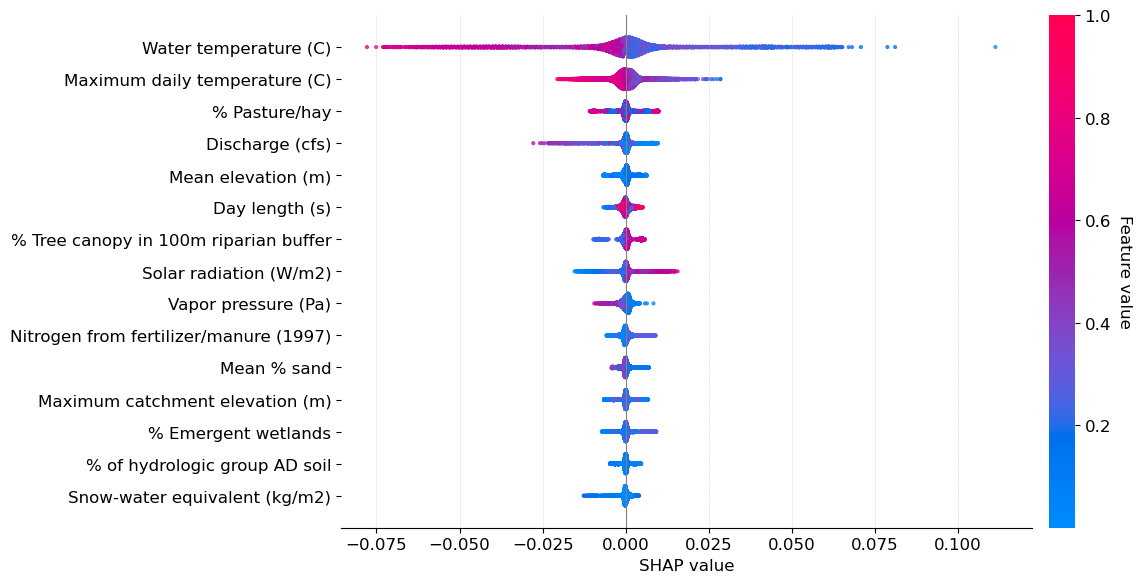

In [255]:
# Need to call this to be able to use shap plotting functions
shap.initjs()

# Get the expected value and 2D shap explainer object for plotting
expected_PT = np.repeat(explainer_PT.expected_value, 9000)
shap_explanation_2d = shap.Explanation(values=shap_values_2d, base_values=expected_PT, feature_names=feature_names, data=data_2d)

# Make beeswarm plot
# shap.plots.beeswarm(shap_explanation_2d, max_display=15)
# Get color map
from shap.plots import colors
red_blue = colors.red_blue

shap_beeswarm_kdepoints(shap_values_2d, data_2d, feature_names, expected_PT, max_display=15, cmap=red_blue, show=False)
plt.show()

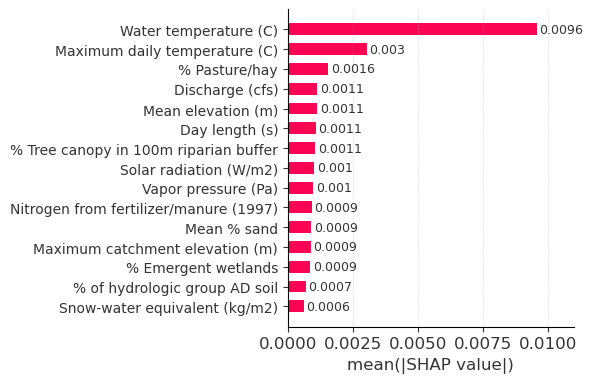

(<Figure size 600x400 with 1 Axes>, <AxesSubplot:xlabel='mean(|SHAP value|)'>)

In [372]:
shap_bar_plot(shap_explanation_2d, max_display=15, show=True)

In [77]:
tf.compat.v1.disable_eager_execution()
import tensorflow.python.keras.backend as K
with h5py.File(MODEL_DIR + '/TL_LSTM.weights.h5', 'r') as f:
    with tf.compat.v1.Session() as sess:
        K.set_session(sess)
        # Build the model
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        # n_features = len(X_train_master.columns)
        model_FT = build_model_shap(hidden_layers, hidden_units, optimizer, window_length, n_features,
                            dropout=dropout, lr=learning_rate, custom_loss_fn=None, batch_norm=False)
        model_FT.summary()
        
        # Layer names as per the HDF5 file
        dense_vars = f['/layers/dense/vars']
        lstm_vars = f['/layers/lstm/cell/vars']
        
        # Extract weights from the file and assign to model layers
        # LSTM layer weights (order: [kernel, recurrent_kernel, bias])
        
        lstm_weights = [np.array(lstm_vars[str(i)]) for i in range(len(lstm_vars))]
        model_FT.layers[0].set_weights(lstm_weights)
        
        # Dense layer weights (order: [kernel, bias])
        dense_weights = [np.array(dense_vars[str(i)]) for i in range(len(dense_vars))]
        model_FT.layers[2].set_weights(dense_weights)
        
        explainer_FT = shap.DeepExplainer(model_FT, X_master_rs[:1000], session=sess)
        shap_values_FT = explainer_FT.shap_values(X_master_rs[:1000])

2025-04-21 11:48:02.730309: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-04-21 11:48:02.730340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 8)                 1408      
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 1,417
Trainable params: 1,417
Non-trainable params: 0
_________________________________________________________________


In [78]:
# Create Explanation object from shap values for plotting purposes
shap_explainer_FT = shap.Explanation(values=shap_values_FT, base_values=explainer_FT.expected_value, data=X_master_rs[:1000])

# Flatten shap values along the second dimension to turn (1000, 9, 35) array into (9000, 35) array
shap_values_2d_FT = shap_explainer_FT[0].values.reshape(-1, shap_explainer_FT[0].values.shape[-1])   # (9000, 35)
data_2d_FT = shap_explainer_FT.data.reshape(-1, shap_explainer_FT.data.shape[-1])
print(shap_values_2d_FT.shape, data_2d_FT.shape)

(9000, 35) (9000, 35)


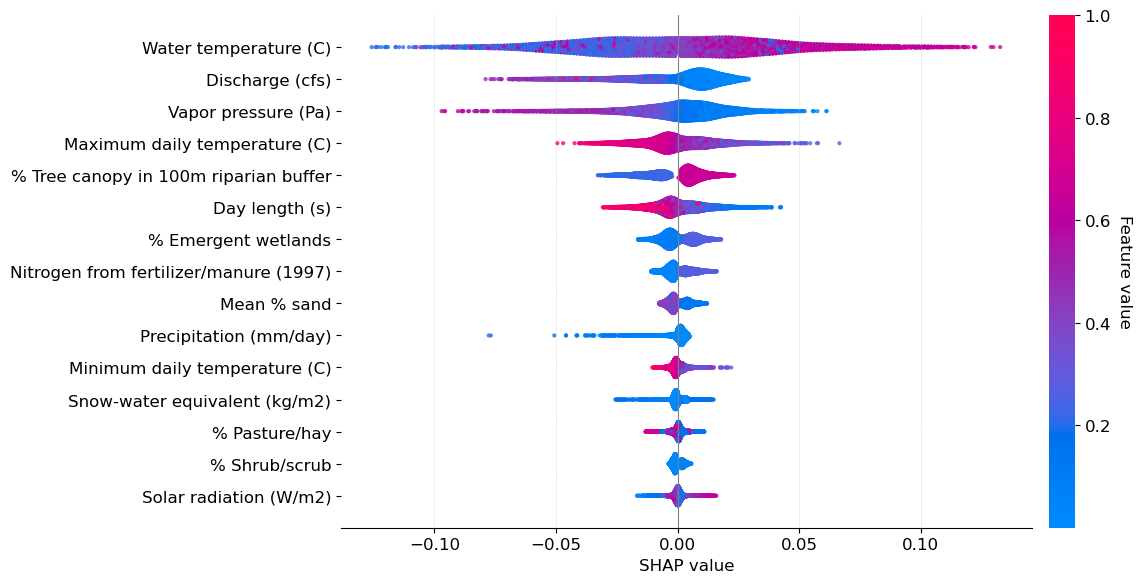

In [242]:
expected_FT = np.repeat(explainer_FT.expected_value, 9000)
shap_explanation_2d_FT = shap.Explanation(values=shap_values_2d_FT, base_values=expected_FT, feature_names=feature_names, data=data_2d_FT)
fig_FT, ax_FT = shap_beeswarm_kdepoints(shap_values_2d_FT, data_2d_FT, feature_names, cmap=red_blue)

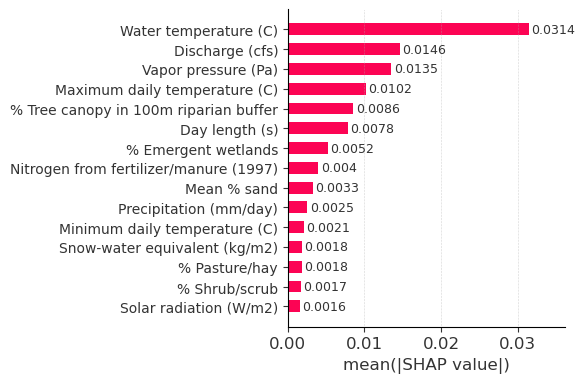

(<Figure size 600x400 with 1 Axes>, <AxesSubplot:xlabel='mean(|SHAP value|)'>)

In [373]:
shap_bar_plot(shap_explanation_2d_FT, max_display=15, show=True)

In [83]:
tf.compat.v1.disable_eager_execution()
import tensorflow.python.keras.backend as K
with h5py.File(MODEL_DIR + '/FP_LSTM.weights.h5', 'r') as f:
    with tf.compat.v1.Session() as sess:
        K.set_session(sess)
        # Build the model
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        # n_features = len(X_train_master.columns)
        model_FP = build_model_shap(hidden_layers, hidden_units, optimizer, window_length, n_features,
                            dropout=dropout, lr=learning_rate, custom_loss_fn=None, batch_norm=False)
        model_FP.summary()
        
        # Layer names as per the HDF5 file
        dense_vars = f['/layers/dense/vars']
        lstm_vars = f['/layers/lstm/cell/vars']
        
        # Extract weights from the file and assign to model layers
        # LSTM layer weights (order: [kernel, recurrent_kernel, bias])
        
        lstm_weights = [np.array(lstm_vars[str(i)]) for i in range(len(lstm_vars))]
        model_FP.layers[0].set_weights(lstm_weights)
        
        # Dense layer weights (order: [kernel, bias])
        dense_weights = [np.array(dense_vars[str(i)]) for i in range(len(dense_vars))]
        model_FP.layers[2].set_weights(dense_weights)
        
        explainer_FP = shap.DeepExplainer(model_FP, X_master_rs[:1000], session=sess)
        shap_values_FP = explainer_FP.shap_values(X_master_rs[:1000])

2025-04-21 11:50:45.580319: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-04-21 11:50:45.580397: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 8)                 1408      
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 1,417
Trainable params: 1,417
Non-trainable params: 0
_________________________________________________________________


In [84]:
# Create Explanation object from shap values for plotting purposes
shap_explainer_FP = shap.Explanation(values=shap_values_FP, base_values=explainer_FP.expected_value, data=X_master_rs[:1000])

# Flatten shap values along the second dimension to turn (1000, 9, 35) array into (9000, 35) array
shap_values_2d_FP = shap_explainer_FP[0].values.reshape(-1, shap_explainer_FP[0].values.shape[-1])   # (9000, 35)
data_2d_FP = shap_explainer_FP.data.reshape(-1, shap_explainer_FP.data.shape[-1])
print(shap_values_2d_FP.shape, data_2d_FP.shape)

(9000, 35) (9000, 35)


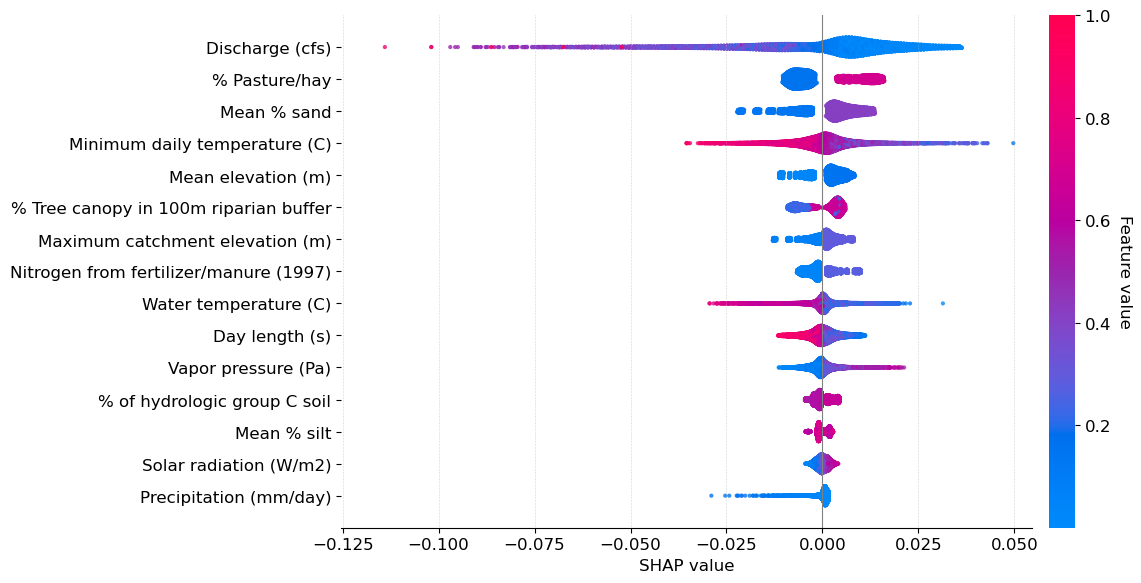

In [244]:
expected_FP = np.repeat(explainer_FP.expected_value, 1000)
shap_explanation_2d_FP = shap.Explanation(values=shap_values_2d_FP, base_values=expected_FP, feature_names=feature_names, data=data_2d_FP)
fig_FP, ax_FP = shap_beeswarm_kdepoints(shap_values_2d_FP, data_2d_FP, feature_names, cmap=red_blue)

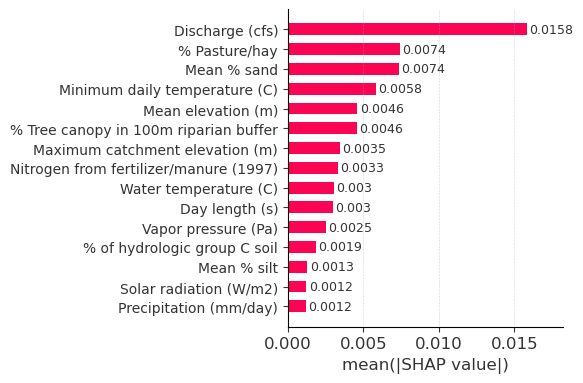

(<Figure size 600x400 with 1 Axes>, <AxesSubplot:xlabel='mean(|SHAP value|)'>)

In [374]:
shap_bar_plot(shap_explanation_2d_FP, max_display=15, show=True)

In [90]:
tf.compat.v1.disable_eager_execution()
import tensorflow.python.keras.backend as K
with h5py.File(MODEL_DIR + '/TL_FRZ_R_LSTM.weights.h5', 'r') as f:
    with tf.compat.v1.Session() as sess:
        K.set_session(sess)
        # Build the model
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        # n_features = len(X_train_master.columns)
        model_FRZ = build_model_shap(hidden_layers, hidden_units, optimizer, window_length, n_features,
                            dropout=dropout, lr=learning_rate, custom_loss_fn=None, batch_norm=False)
        model_FRZ.summary()
        
        # Layer names as per the HDF5 file
        dense_vars = f['/layers/dense/vars']
        lstm_vars = f['/layers/lstm/cell/vars']
        
        # Extract weights from the file and assign to model layers
        # LSTM layer weights (order: [kernel, recurrent_kernel, bias])
        
        lstm_weights = [np.array(lstm_vars[str(i)]) for i in range(len(lstm_vars))]
        model_FRZ.layers[0].set_weights(lstm_weights)
        
        # Dense layer weights (order: [kernel, bias])
        dense_weights = [np.array(dense_vars[str(i)]) for i in range(len(dense_vars))]
        model_FRZ.layers[2].set_weights(dense_weights)
        
        explainer_FRZ = shap.DeepExplainer(model_FRZ, X_master_rs[:1000], session=sess)
        shap_values_FRZ = explainer_FRZ.shap_values(X_master_rs[:1000])

2025-04-21 11:56:37.447499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-04-21 11:56:37.447544: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 8)                 1408      
_________________________________________________________________
dropout_6 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 1,417
Trainable params: 1,417
Non-trainable params: 0
_________________________________________________________________


In [91]:
# Create Explanation object from shap values for plotting purposes
shap_explainer_FRZ = shap.Explanation(values=shap_values_FRZ, base_values=explainer_FRZ.expected_value, data=X_master_rs[:1000])

# Flatten shap values along the second dimension to turn (1000, 9, 35) array into (9000, 35) array
shap_values_2d_FRZ = shap_explainer_FRZ[0].values.reshape(-1, shap_explainer_FRZ[0].values.shape[-1])   # (9000, 35)
data_2d_FRZ = shap_explainer_FRZ.data.reshape(-1, shap_explainer_FRZ.data.shape[-1])
print(shap_values_2d_FRZ.shape, data_2d_FRZ.shape)

(9000, 35) (9000, 35)


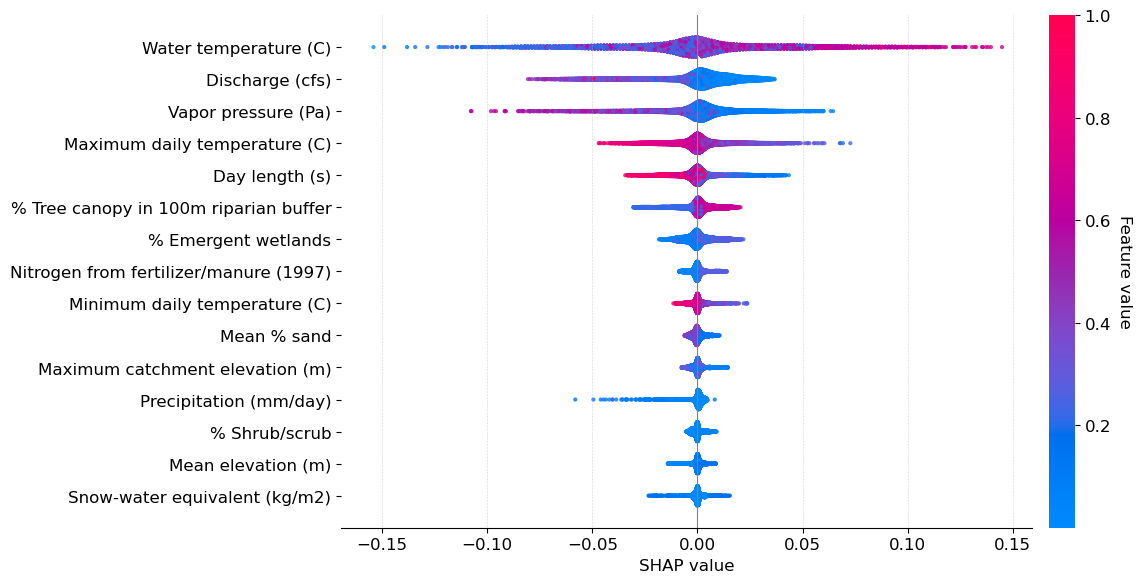

In [245]:
expected_FRZ = np.repeat(explainer_FRZ.expected_value, 1000)
shap_explanation_2d_FRZ = shap.Explanation(values=shap_values_2d_FRZ, base_values=expected_FRZ, feature_names=feature_names, data=data_2d_FRZ)
fig_FRZ, ax_FRZ = shap_beeswarm_kdepoints(shap_values_2d_FRZ, data_2d_FRZ, feature_names, cmap=red_blue)

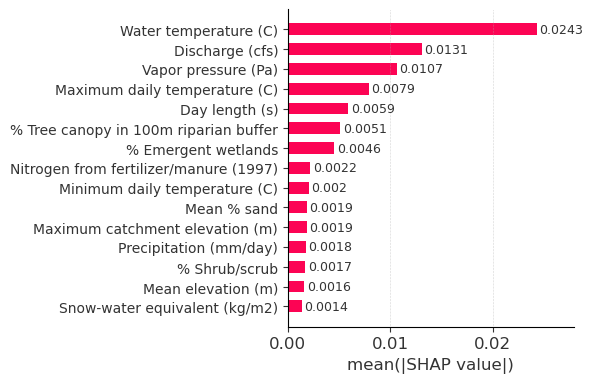

(<Figure size 600x400 with 1 Axes>, <AxesSubplot:xlabel='mean(|SHAP value|)'>)

In [375]:
shap_bar_plot(shap_explanation_2d_FRZ, max_display=15, show=True)

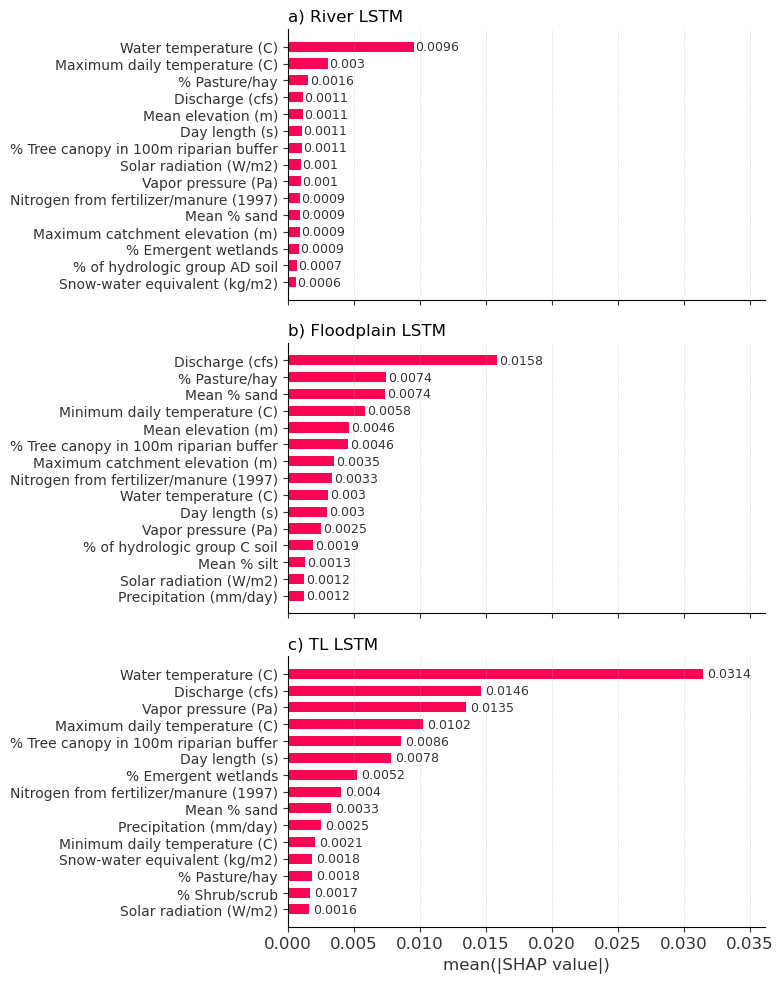

In [ ]:
# Make figure of all plots
# List of SHAP explanation objects for your models
shap_explanations = [shap_explanation_2d,  shap_explanation_2d_FP, shap_explanation_2d_FT]
model_names = ["a) River LSTM", "b) Floodplain LSTM", "c) TL LSTM"]

# Create a figure with 3 rows and 1 column
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# Plot each model in a loop
for i, shap_exp in enumerate(shap_explanations):
    # Create bar plot in the first column (left)
    plt.sca(axs[i])
    shap_bar_plot(
        shap_exp,
        max_display=15,          
        ax=axs[i],
        show=False             
    )
    axs[i].set_title(model_names[i], loc="left", fontsize=12)
    if i != 2:
        axs[i].set_xlabel("")

plt.savefig(FIGURE_DIR + '/ShapValues/feature_importances.png', dpi=600, bbox_inches="tight")
plt.show()

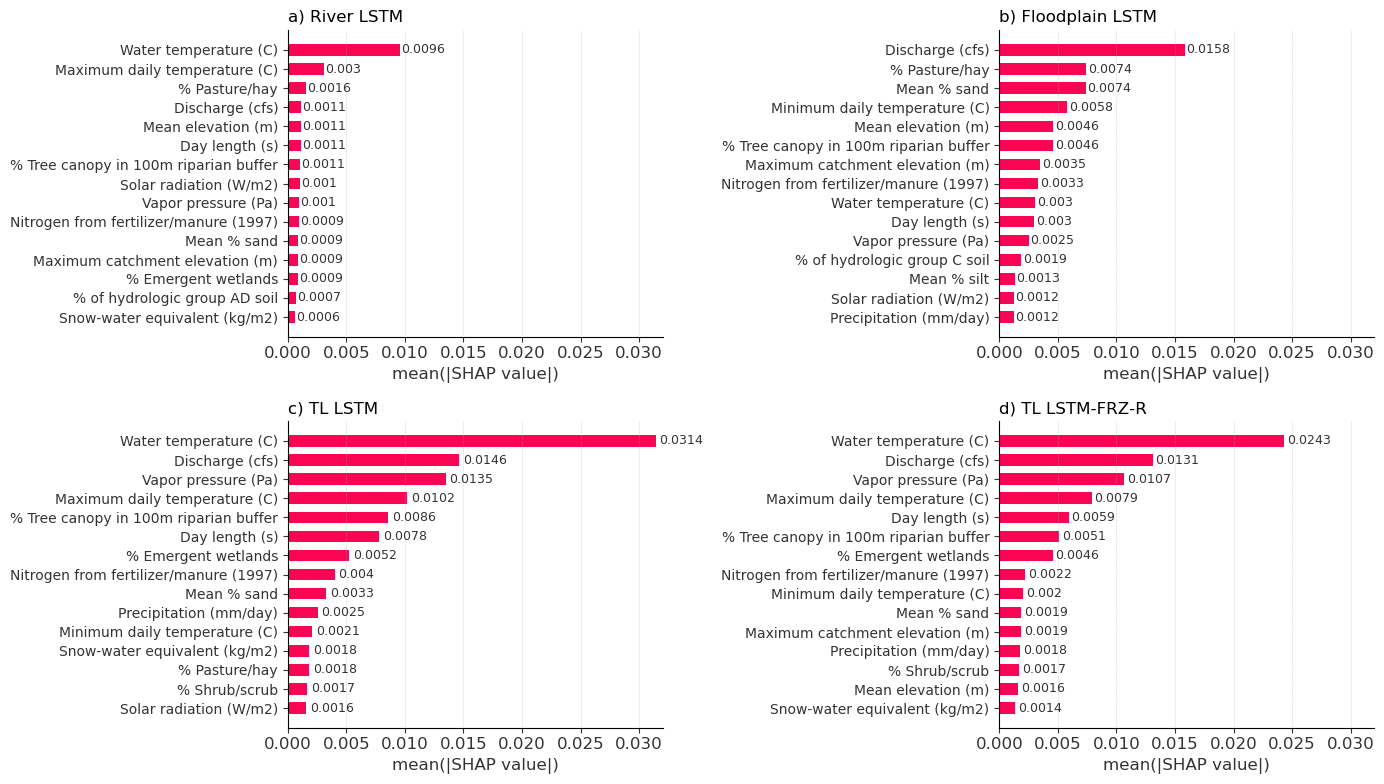

In [ ]:
shap_explanations = [
    shap_explanation_2d,
    shap_explanation_2d_FP,
    shap_explanation_2d_FT,
    shap_explanation_2d_FRZ,
]
model_names = [
    "a) River LSTM",
    "b) Floodplain LSTM",
    "c) TL LSTM",
    "d) TL LSTM‑FRZ‑R",
]
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.ravel()

for i, shap_exp in enumerate(shap_explanations):
    shap_bar_plot(
        shap_exp,
        max_display=15,          
        ax=axs[i],
        show=False,
        x_max = 0.032             
    )
    axs[i].set_title(model_names[i], loc="left", fontsize=12)
    
fig.savefig(FIGURE_DIR + "/ShapValues/feature_importances_with_FRZ.png",
            dpi=600, bbox_inches="tight")
plt.show()


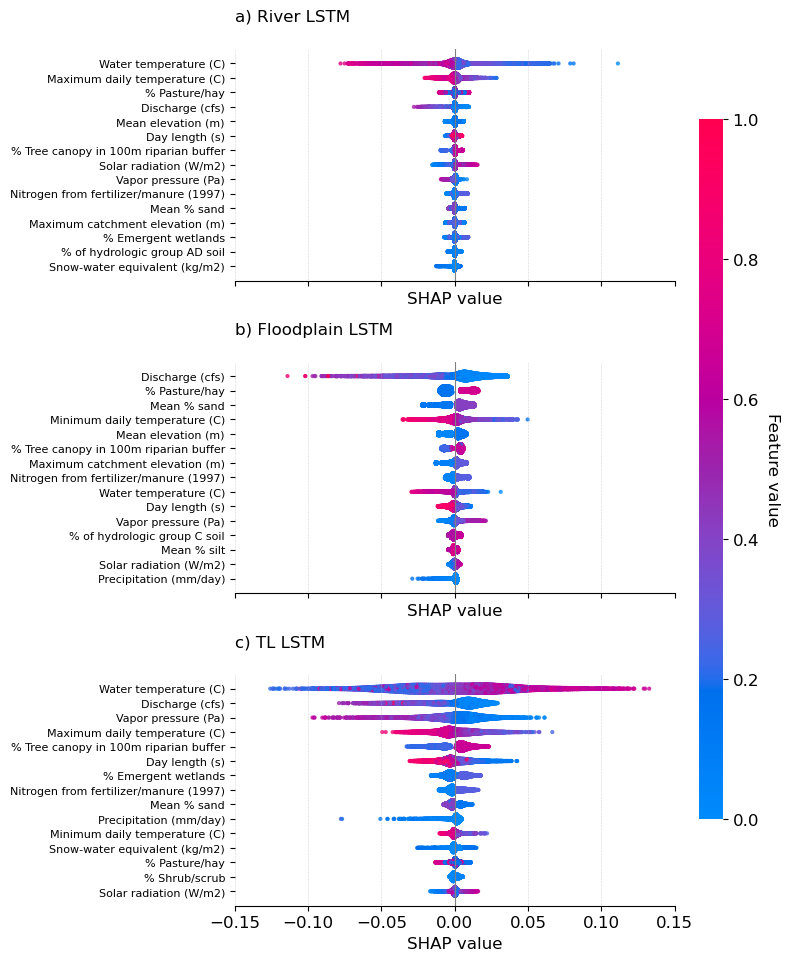

In [ ]:
# Create a figure with 3 rows and 1 columns
shap_explanations = [shap_values_2d,  shap_values_2d_FP, shap_values_2d_FT]

plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# Plot each model in a loop
for i, shap_exp in enumerate(shap_explanations):
    # Create bar plot in the first column (left)
    plt.sca(axs[i])
    shap_beeswarm_kdepoints(shap_exp, data_2d, feature_names, cmap=red_blue, ax=axs[i], show=False, x_min=-0.15, x_max=0.15, colorbar=False)
    axs[i].set_title(f'{model_names[i]}', fontsize=12, pad=20, loc='left')
    axs[i].tick_params(axis='y', labelsize=8) 

sm = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 1), cmap=red_blue)
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])   # [left, bottom, width, height]
fig.colorbar(sm, cax=cbar_ax).set_label("Feature value", rotation=270, labelpad=15)
# Remove colorbar outline
for spine in cbar_ax.spines.values():
    spine.set_visible(False)
    
fig.subplots_adjust(left=0.3, right=0.85, hspace=0.35, wspace=0.35, top=0.92)
plt.savefig(FIGURE_DIR + '/ShapValues/beeswarm_plot.png', dpi=600)

plt.show()

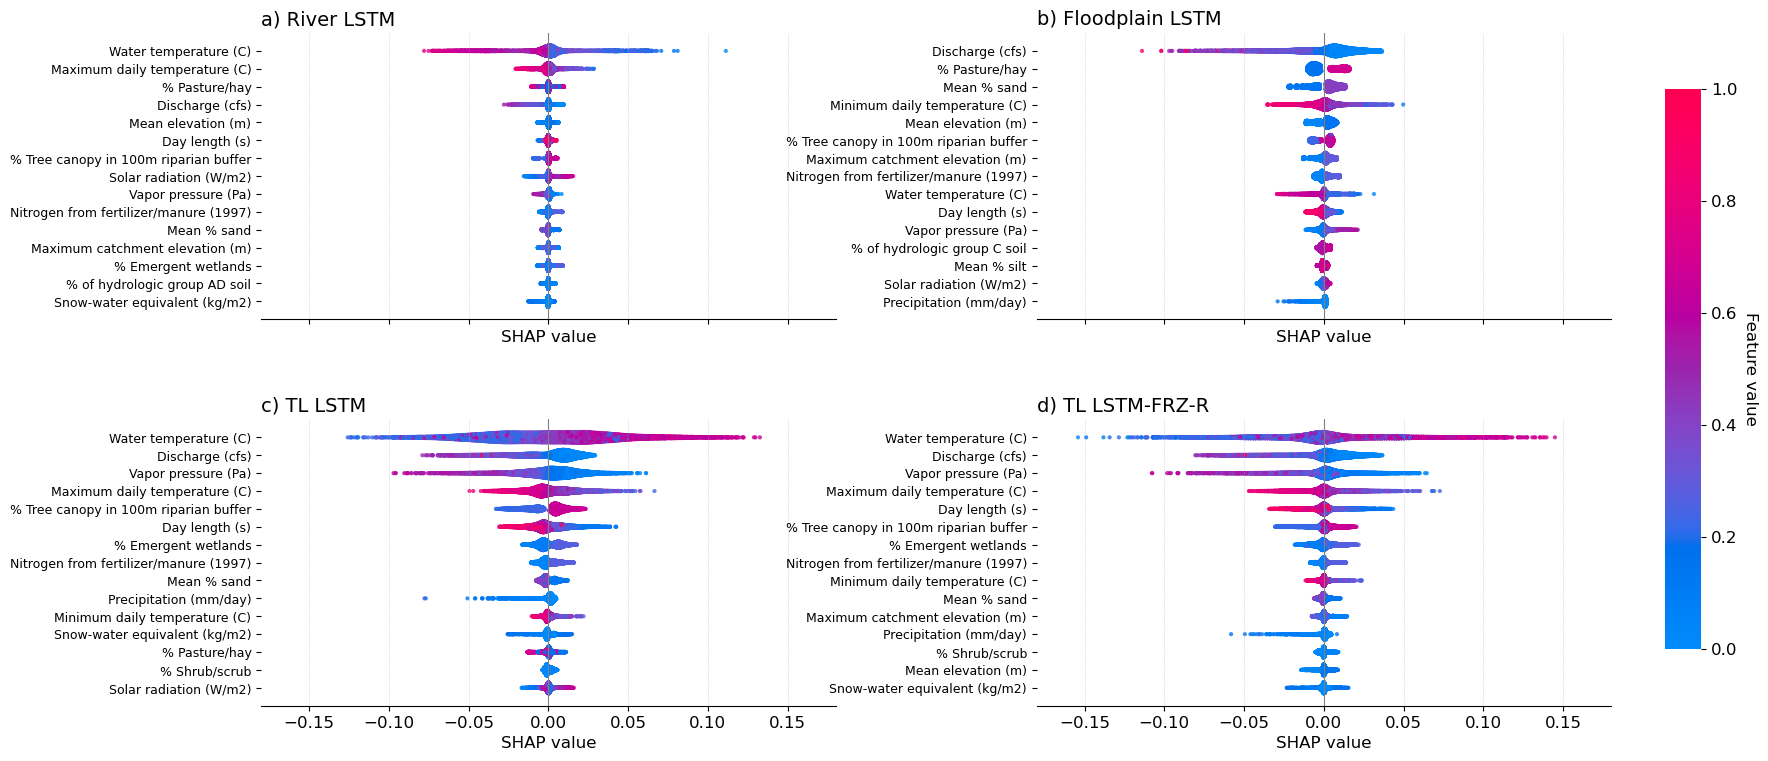

In [294]:
shap_explanations = [shap_values_2d,  shap_values_2d_FP, shap_values_2d_FT, shap_values_2d_FRZ]

plt.rcParams.update({"font.size": 12})
fig, axs = plt.subplots(
    nrows=2, ncols=2, figsize=(18, 8),  # wider figure for 2×2
    sharex=True, sharey=False
)

# flatten the 2‑D array of axes -> convenient 1‑D list
axs = axs.ravel()

# ------------------------------------------------------------------
# loop through each model / subplot
# ------------------------------------------------------------------
for i, shap_exp in enumerate(shap_explanations):
    shap_beeswarm_kdepoints(
        shap_exp,
        data_2d,
        feature_names,
        cmap=red_blue,
        show=False,
        ax=axs[i],             # draw in the i‑th subplot
        colorbar=False,        # omit colourbar inside each panel
        x_min = -0.18,
        x_max = 0.18
    )
    axs[i].set_title(model_names[i], fontsize=14, loc="left")
    axs[i].tick_params(axis="y", labelsize=9)

# Optional: add ONE global colourbar
sm = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, 1), cmap=red_blue)
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])   # [left, bottom, width, height]
fig.colorbar(sm, cax=cbar_ax).set_label("Feature value", rotation=270, labelpad=15)
# Remove colorbar outline
for spine in cbar_ax.spines.values():   
    spine.set_visible(False)

fig.subplots_adjust(left=0.15, right=0.90, hspace=0.35, wspace=0.35, top=0.92)
# plt.tight_layout()
plt.savefig(FIGURE_DIR + '/ShapValues/beeswarm_plot_with_FRZ.png', dpi=600)
plt.show()